In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import copy

# --- CONFIGURATION ---
config = {
    'data_path': r'dataset_split/',
    'model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'batch_size': 16,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 3,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'drop_path_rate': 0.2,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
}

In [2]:
# --- DATA PREPARATION, TRAINING, AND VALIDATION FUNCTIONS ---

def get_data_loaders(data_path, img_size, batch_size, num_workers, pin_memory):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'val'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'test'), transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    class_names = train_dataset.classes
    print(f"Found classes: {class_names}")
    return train_loader, val_loader, test_loader, class_names

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
    acc = correct_predictions.double() / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), acc.item()

print("✅ Helper functions are defined.")

✅ Helper functions are defined.


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
train_loader, val_loader, test_loader, class_names = get_data_loaders(
    config['data_path'], config['img_size'], config['batch_size'], config['num_workers'], config['pin_memory']
)
num_classes = len(class_names)

# Load model
model = timm.create_model(
    config['model_name'], pretrained=True, num_classes=num_classes,
    drop_rate=config['drop_rate'], drop_path_rate=config['drop_path_rate']
)
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

print("\n✅ Model and data are ready for training!")

Using device: cuda
Found classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

✅ Model and data are ready for training!


In [4]:
# --- PHASE 1: HEAD TRAINING ---
print("\n--- Starting Phase 1: Head Training ---")
for param in model.parameters(): param.requires_grad = False
for param in model.head.parameters(): param.requires_grad = True
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config['head_lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['head_epochs'], eta_min=1e-6)
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ New best model saved!")




--- Starting Phase 1: Head Training ---

Epoch 1/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


Train Loss: 1.3888 | Val Loss: 1.2302 | Val Acc: 0.5257
✅ New best model saved!

Epoch 2/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Train Loss: 1.3840 | Val Loss: 1.2306 | Val Acc: 0.5429
✅ New best model saved!

Epoch 3/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.59it/s]


Train Loss: 1.3690 | Val Loss: 1.2337 | Val Acc: 0.6857
✅ New best model saved!

Epoch 4/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


Train Loss: 1.3752 | Val Loss: 1.3004 | Val Acc: 0.5114

Epoch 5/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.61it/s]


Train Loss: 1.3477 | Val Loss: 1.1963 | Val Acc: 0.5629

Epoch 6/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Train Loss: 1.3554 | Val Loss: 1.1726 | Val Acc: 0.5400

Epoch 7/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.68it/s]


Train Loss: 1.3411 | Val Loss: 1.2023 | Val Acc: 0.5143

Epoch 8/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Train Loss: 1.3464 | Val Loss: 1.1832 | Val Acc: 0.5400

Epoch 9/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.68it/s]


Train Loss: 1.3390 | Val Loss: 1.2048 | Val Acc: 0.5114

Epoch 10/10


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.67it/s]

Train Loss: 1.3387 | Val Loss: 1.1892 | Val Acc: 0.5200


In [5]:
# --- PHASE 2: FULL NETWORK FINE-TUNING ---
print("\n--- Starting Phase 2: Full Fine-Tuning ---")
for param in model.parameters(): param.requires_grad = True
model.load_state_dict(best_model_wts)
optimizer = optim.AdamW(model.parameters(), lr=config['full_train_lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'] - config['lr_warmup_epochs'], eta_min=1e-6)
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda e: (e+1)/config['lr_warmup_epochs'] if e < config['lr_warmup_epochs'] else 1)
patience_counter = 0

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    if epoch < config['lr_warmup_epochs']: warmup_scheduler.step()
    else: scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ New best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= config['patience']:
        print("Early stopping triggered.")
        break

print("\n🎉 Training finished!")


--- Starting Phase 2: Full Fine-Tuning ---

Epoch 1/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.53it/s]


Train Loss: 1.2823 | Val Loss: 0.9002 | Val Acc: 0.7600
✅ New best model saved!

Epoch 2/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


Train Loss: 1.1625 | Val Loss: 0.8843 | Val Acc: 0.7600

Epoch 3/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.74it/s]


Train Loss: 1.0493 | Val Loss: 0.8738 | Val Acc: 0.7543

Epoch 4/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]


Train Loss: 0.9856 | Val Loss: 0.8759 | Val Acc: 0.7657
✅ New best model saved!

Epoch 5/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Train Loss: 0.9593 | Val Loss: 0.8682 | Val Acc: 0.7714
✅ New best model saved!

Epoch 6/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


Train Loss: 0.9453 | Val Loss: 0.9443 | Val Acc: 0.7486

Epoch 7/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Train Loss: 0.9229 | Val Loss: 0.8587 | Val Acc: 0.7571

Epoch 8/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.53it/s]


Train Loss: 0.9041 | Val Loss: 0.8133 | Val Acc: 0.8029
✅ New best model saved!

Epoch 9/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.57it/s]


Train Loss: 0.8980 | Val Loss: 0.8173 | Val Acc: 0.7943

Epoch 10/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Train Loss: 0.8723 | Val Loss: 0.8193 | Val Acc: 0.8171
✅ New best model saved!

Epoch 11/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]


Train Loss: 0.8599 | Val Loss: 0.7819 | Val Acc: 0.7914

Epoch 12/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


Train Loss: 0.8572 | Val Loss: 0.8045 | Val Acc: 0.7800

Epoch 13/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


Train Loss: 0.8515 | Val Loss: 0.8091 | Val Acc: 0.7886

Epoch 14/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.48it/s]


Train Loss: 0.8340 | Val Loss: 0.8066 | Val Acc: 0.7971

Epoch 15/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]


Train Loss: 0.8334 | Val Loss: 0.7904 | Val Acc: 0.8000

Epoch 16/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]


Train Loss: 0.8277 | Val Loss: 0.7926 | Val Acc: 0.7943

Epoch 17/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]


Train Loss: 0.8195 | Val Loss: 0.7703 | Val Acc: 0.8057

Epoch 18/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.50it/s]


Train Loss: 0.8156 | Val Loss: 0.7629 | Val Acc: 0.8029

Epoch 19/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.68it/s]


Train Loss: 0.8195 | Val Loss: 0.7969 | Val Acc: 0.7943

Epoch 20/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


Train Loss: 0.7972 | Val Loss: 0.7817 | Val Acc: 0.8086

Epoch 21/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


Train Loss: 0.7990 | Val Loss: 0.7545 | Val Acc: 0.8029

Epoch 22/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Train Loss: 0.7932 | Val Loss: 0.7445 | Val Acc: 0.8229
✅ New best model saved!

Epoch 23/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.73it/s]


Train Loss: 0.7952 | Val Loss: 0.7476 | Val Acc: 0.8229

Epoch 24/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]


Train Loss: 0.7816 | Val Loss: 0.7584 | Val Acc: 0.8171

Epoch 25/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


Train Loss: 0.7734 | Val Loss: 0.7289 | Val Acc: 0.8486
✅ New best model saved!

Epoch 26/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.62it/s]


Train Loss: 0.7941 | Val Loss: 0.7471 | Val Acc: 0.8200

Epoch 27/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.74it/s]


Train Loss: 0.7764 | Val Loss: 0.7944 | Val Acc: 0.8086

Epoch 28/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Train Loss: 0.7801 | Val Loss: 0.7315 | Val Acc: 0.8229

Epoch 29/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Train Loss: 0.7629 | Val Loss: 0.7376 | Val Acc: 0.8114

Epoch 30/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


Train Loss: 0.7703 | Val Loss: 0.7318 | Val Acc: 0.8486

Epoch 31/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s]


Train Loss: 0.7507 | Val Loss: 0.7204 | Val Acc: 0.8371

Epoch 32/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


Train Loss: 0.7579 | Val Loss: 0.7389 | Val Acc: 0.8171

Epoch 33/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


Train Loss: 0.7550 | Val Loss: 0.7184 | Val Acc: 0.8457

Epoch 34/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


Train Loss: 0.7467 | Val Loss: 0.7356 | Val Acc: 0.8229

Epoch 35/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


Train Loss: 0.7313 | Val Loss: 0.7089 | Val Acc: 0.8400

Epoch 36/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]


Train Loss: 0.7384 | Val Loss: 0.7170 | Val Acc: 0.8400

Epoch 37/80


Validating: 100%|██████████| 22/22 [00:03<00:00,  6.52it/s]

Train Loss: 0.7296 | Val Loss: 0.6967 | Val Acc: 0.8486
Early stopping triggered.

🎉 Training finished!



--- Evaluating on Test Set ---


Testing: 100%|██████████| 23/23 [00:03<00:00,  6.94it/s]



Final Test Accuracy: 83.01%

Classification Report:
                precision    recall  f1-score   support

          Mild       0.63      0.53      0.58        36
      Moderate       0.68      0.88      0.77        95
         No_DR       0.98      0.98      0.98       181
Proliferate_DR       0.84      0.57      0.68        28
        Severe       0.40      0.11      0.17        19

      accuracy                           0.83       359
     macro avg       0.71      0.61      0.63       359
  weighted avg       0.82      0.83      0.82       359


Improved confusion matrix saved to confusion_matrix_eva02_improved.png


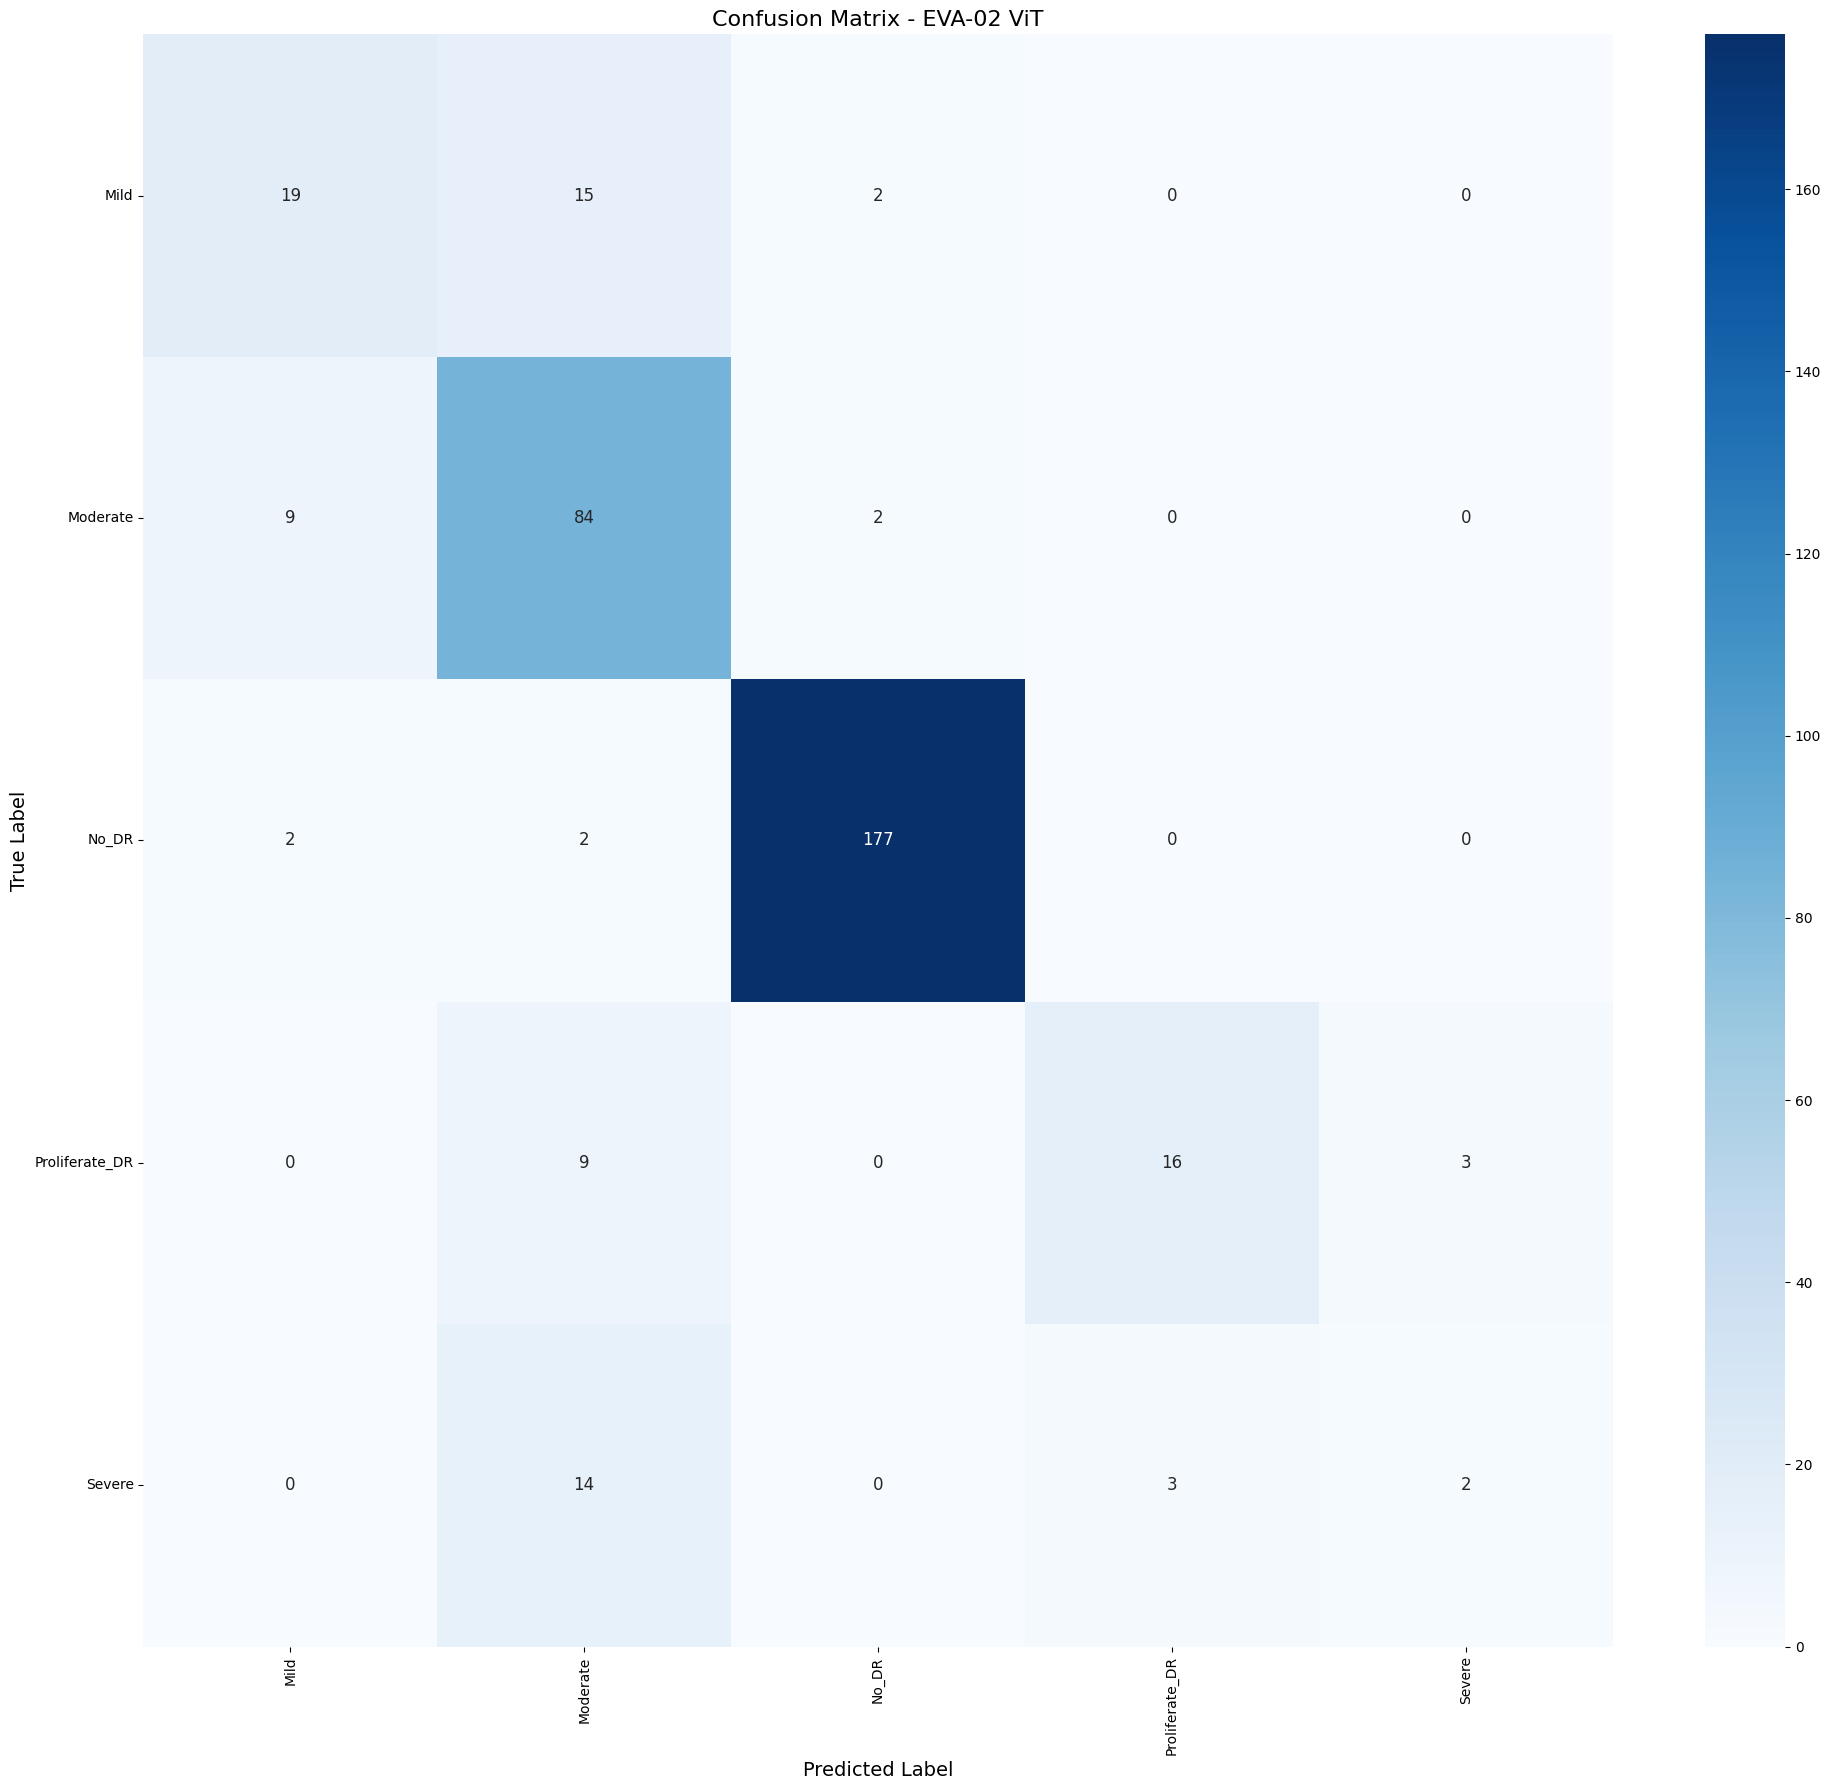

In [6]:
# --- FINAL EVALUATION ON TEST SET (WITH IMPROVED PLOTTING) ---
print("\n--- Evaluating on Test Set ---")

# Create a new instance of the model architecture
evaluation_model = timm.create_model(
    config['model_name'], pretrained=False, num_classes=num_classes
)
# Load the best weights saved during training
evaluation_model.load_state_dict(torch.load('best_model.pth'))
evaluation_model.to(device)
evaluation_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = evaluation_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(f"\nFinal Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# --- Generate Improved Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

# Create a much larger figure to give space for labels
plt.figure(figsize=(20, 18))

# Use Seaborn's heatmap with customizations
sns.heatmap(
    cm, 
    annot=True,          # Show the numbers in the cells
    fmt='d',             # Format as integers
    cmap='Blues',        # Color scheme
    xticklabels=class_names, 
    yticklabels=class_names,
    annot_kws={"size": 12} # Set the font size for the numbers
)

# Rotate labels for better readability
plt.xticks(rotation=90) # Rotate x-axis labels (Predicted)
plt.yticks(rotation=0)  # Keep y-axis labels horizontal (True)

# Add titles and labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix - EVA-02 ViT', fontsize=16)

# Use tight_layout to ensure everything fits without overlapping
plt.tight_layout()

# Save the high-quality figure
plt.savefig('confusion_matrix_eva02_improved.png', dpi=300)
print("\nImproved confusion matrix saved to confusion_matrix_eva02_improved.png")
plt.show()